In [1]:
#Inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import plotly.plotly as py
import seaborn as sns
import statsmodels.api as sm
sns.set_palette([ "#30a2da", "#fc4f30", "#e5ae38", "#6d904f", "#8b8b8b"])

/Users/Jason/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
shooting_data=pd.read_csv("Rochester_Shooting_Victims.csv")
homicide_data =pd.read_csv("RochesterNY_Homicides.csv")
all_crime_data=pd.read_csv("RPD__Part_I_Crime_2011_to_Present.csv")

In [3]:
shooting_data['Statute_Text']="shooting"

In [4]:
shooting_data.rename({"ObjectID": "OBJECTID","Address":"Geocode_Address","Occurred_Date":"Date","Occurred_Month":"Month",
                     "Occurred_Year":"Year"}, 
                     axis='columns', inplace=True)

In [5]:
homicide_data['Statute_Text']="homicide"

In [6]:
homicide_data.rename({"Id": "ID","CaseNumber":"Case_Number","CaseStatus":"Case_Status","Address":"Geocode_Address",
                     "Section":"Patrol_Section","Beat":"Geo_Beat","OccurredDate":"Occurred_Date","DateOfDeath":"Date",
                     "DateOfDeathMonth":"Month","DateOfDeathYear":"Year"}, 
                     axis='columns', inplace=True)

In [7]:
all_crime_data.columns

Index([u'X', u'Y', u'OBJECTID', u'Geocode_Address', u'Geocode_Street',
       u'Case_Number', u'OccurredFrom_Date_Year', u'OccurredFrom_Date_Month',
       u'OccurredFrom_Time', u'OccurredFrom_Timestamp',
       u'OccurredThrough_Date_Year', u'OccurredThrough_Date_Month',
       u'OccurredThrough_Time', u'OccurredThrough_Timestamp',
       u'Reported_Date_Year', u'Reported_Date_Month', u'Reported_Time',
       u'Reported_Timestamp', u'Address_StreetFull', u'Address_City',
       u'Address_State', u'Patrol_Beat', u'Patrol_Section', u'Case_Status',
       u'Statute_Title', u'Statute_Section', u'Statute_Subsection',
       u'Statute_Degree', u'Statute_Class', u'Statute_Category',
       u'Statute_Text', u'Statute_Description', u'Statute_CrimeCategory',
       u'Statute_Attempted', u'Weapon_Description', u'Larceny_Type',
       u'Location_Type', u'Geo_Beat', u'Geo_Section', u'Geo_Section_Num'],
      dtype='object')

In [8]:
all_crime_data["Date"]=all_crime_data.OccurredFrom_Timestamp

In [9]:
all_crime_data["Month"]=all_crime_data.OccurredFrom_Date_Month

In [10]:
all_crime_data["Year"]=all_crime_data.OccurredThrough_Date_Year

In [11]:
frames = [all_crime_data, shooting_data, homicide_data]
#combine all 3 datasets
result = pd.concat(frames)

In [75]:
result.shape

(82475, 61)

In [50]:
np.count_nonzero(all_crime_data.Case_Number.unique())

78211

In [51]:
all_crime_data.shape
#They are not equal, indicating there are multiple reports sharing the same case number

(78268, 43)

In [52]:
np.count_nonzero(homicide_data.Case_Number.unique())

702

In [53]:
homicide_data.shape
#They are equal, indicating there are no multiple reports sharing the same case number

(702, 23)

In [54]:
np.count_nonzero(shooting_data.Case_Number.unique())

3246

In [55]:
shooting_data.shape
#They are not equal, indicating there are  multiple reports sharing the same case number

(3505, 18)

In [56]:
#We will combine the data first and remove the duplicates to prevent double counting.
result.index=pd.DatetimeIndex(result.Date)

In [57]:
#filter data to the ones from 2011 only because the largest dataset (all_crime_data) do not have record before 2011
all_crimes_from2011=result[result.index>=np.datetime64('2011-01-01')]

In [72]:
all_crimes_from2011_unique=pd.DataFrame(all_crimes_from2011['Case_Number'])
all_crimes_from2011_unique=all_crimes_from2011_unique.drop_duplicates()

Text(0,0.5,u'Number of crimes')

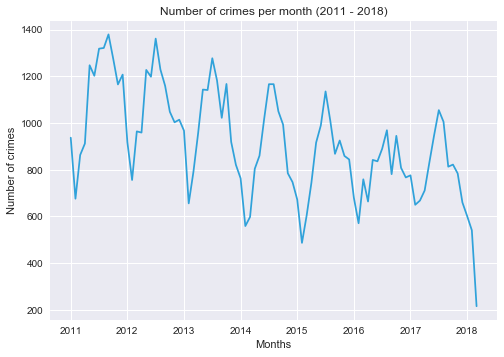

In [76]:
all_crimes_from2011_unique.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2011 - 2018)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')

In [77]:
all_crimes_from2011_monthly_count=pd.DataFrame(all_crimes_from2011_unique.resample('M').size(),columns=['count'])

In [78]:
all_crimes_2011to2016=all_crimes_from2011_monthly_count[all_crimes_from2011_monthly_count.index<np.datetime64('2017-01-01')]

In [79]:
#grid search

In [80]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [81]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(all_crimes_2011to2016,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:919.426387316
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:584.064312638
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:718.753266703
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:696.652236098
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:595.312351106
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:585.587505989
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1084.45215656
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:843.826599918
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:707.004933394
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:562.380957648
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:711.837525375
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:682.3579934
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:587.729539385
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:564.291691457
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:715.022662324
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:558.664503413
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:709.153034741
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:697.871483088
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:573.976525208
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - 

In [82]:
#lowest AIC is ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:535.444737654

In [83]:
mod = sm.tsa.statespace.SARIMAX(all_crimes_2011to2016,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3088      0.168      1.840      0.066      -0.020       0.638
ma.L1         -1.0487      0.138     -7.582      0.000      -1.320      -0.778
ma.S.L12      -0.6024      0.262     -2.296      0.022      -1.116      -0.088
sigma2      6189.6649   2354.007      2.629      0.009    1575.896    1.08e+04


In [84]:
#The summary attribute that results from the output of SARIMAX returns a significant amount of information, 
#but we'll focus our attention on the table of coefficients. The coef column shows the weight 
#(i.e. importance) of each feature and how each one impacts the time series. 
#The P>|z| column informs us of the significance of each feature weight. 
#Here, each weight has a p-value lower than or close to 0.05, so it is reasonable to retain all of them in our model.

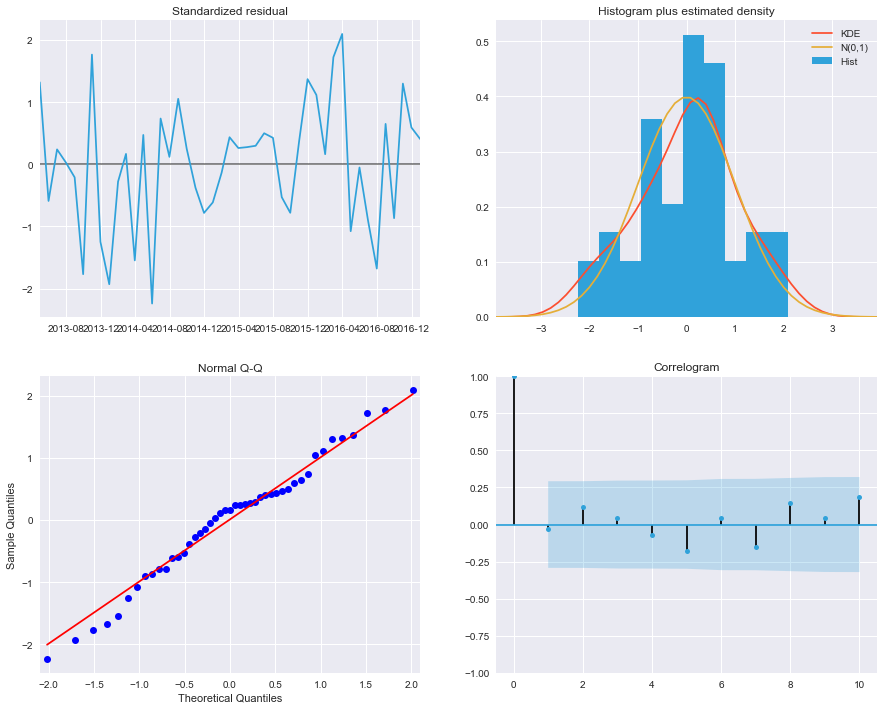

In [85]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [119]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()
#The dynamic=False argument ensures that we produce one-step ahead forecasts, 
#meaning that forecasts at each point are generated using the full history up to that point.

In [120]:
#in-sample prediction

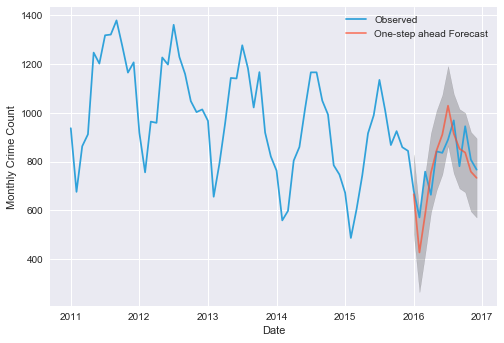

In [121]:
#One-step-ahead prediction
ax = all_crimes_2011to2016['2011':]['count'].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Count')
plt.legend()

plt.show()

In [122]:
#Overall, our forecasts align with the true values very well, showing an overall decreasing trend.

In [123]:
y_forecasted = pred.predicted_mean
y_truth = all_crimes_2011to2016['2016-01-31':]

In [124]:
# Compute the Root Mean Squared Error
mse = ((y_forecasted - y_truth['count']) ** 2).mean()
RMSE=np.sqrt(mse)
MAPE = 100*np.mean(np.abs(y_forecasted-y_truth['count'])/y_truth['count'])
print('The Root Mean Squared Error of our forecasts is {}'.format(round(RMSE, 2)))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(MAPE, 2)))

The Root Mean Squared Error of our forecasts is 94.64
The Mean Absolute Percentage Error of our forecasts is 10.45


In [125]:
#However, a better representation of our true predictive power can be obtained using dynamic forecasts.
#In this case, we only use information from the time series up to a certain point, 
#and after that, forecasts are generated using values from previous forecasted time points.
pred_dynamic = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

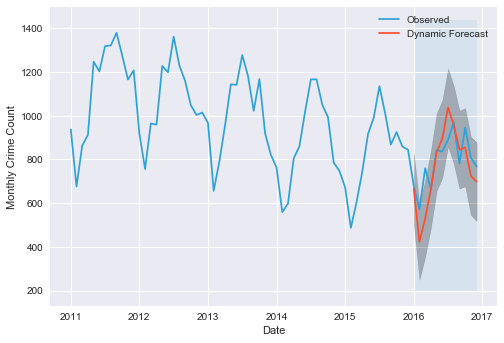

In [126]:
#One-step-ahead in-sample dynamic prediction
ax = all_crimes_2011to2016['2011':]['count'].plot(label='Observed')
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), all_crimes_2011to2016.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Count')

plt.legend()
plt.show()

In [127]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = all_crimes_2011to2016['2016-01-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth['count']) ** 2).mean()
RMSE=np.sqrt(mse)
MAPE = 100*np.mean(np.abs(y_forecasted-y_truth['count'])/y_truth['count'])
print('The Root Mean Squared Error of our forecasts is {}'.format(round(RMSE, 2)))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(MAPE, 2)))
#It is slightly better than "One-step ahead" forecast

The Root Mean Squared Error of our forecasts is 101.66
The Mean Absolute Percentage Error of our forecasts is 10.09


In [128]:
#The Mean Absolute Percentage Error did improve using dynamic forecasts, though RMSE increased a bit

In [129]:
#Get forecast 12 months ahead in future. Here we are forcasting 2017 data, which was kept out of the training process
pred_uc = results.get_forecast(steps=12,dynamic=True)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

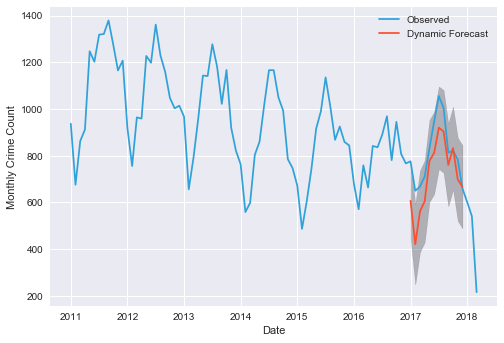

In [130]:
ax = all_crimes_from2011_monthly_count['count'].plot(label='Observed')
pred_uc.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Count')

plt.legend()
plt.show()

In [132]:
# Extract the forcasted and true values of our time series
y_forecasted = pred_uc.predicted_mean
y_truth = all_crimes_from2011_monthly_count['2017-01-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth['count']) ** 2).mean()
RMSE=np.sqrt(mse)
MAPE = 100*np.mean(np.abs(y_forecasted-y_truth['count'])/y_truth['count'])
print('The Root Mean Squared Error of our forecasts is {}'.format(round(RMSE, 2)))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(MAPE, 2)))
#It is slightly better than "One-step ahead" forecast

The Root Mean Squared Error of our forecasts is 116.49
The Mean Absolute Percentage Error of our forecasts is 12.57


In [133]:
#The MAPE is 12.57, similar to in-sample prediction 10.45 which is not bad.

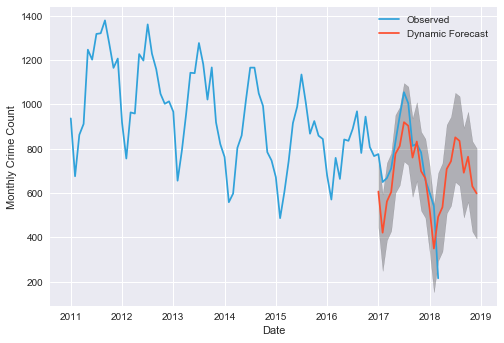

In [134]:
#out-of-sample forecasting
# Get forecast 24 months (2017 and 2018) ahead in future
pred_uc = results.get_forecast(steps=24,dynamic=True)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
ax = all_crimes_from2011_monthly_count['count'].plot(label='Observed')
pred_uc.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Count')

plt.legend()
plt.show()